<a target="_blank" href="https://colab.research.google.com/github/cohere-ai/notebooks/blob/main/notebooks/llmu/RAG_over_Large_Scale_Data.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# RAG over Large Scale Data

*Note: To run the notebook, you must first deploy your own Google Drive connector as a web-based REST API (the steps are outlined in [this article](https://txt.cohere.com/rag-quickstart-connectors/#build-and-deploy-the-connector)).*

This notebook shows how to build a RAG-powered chatbot with Cohere's Chat endpoint using connectors.

Read the accompanying [article here](https://txt.cohere.com/rag-large-scale-data/).

In particular, this notebook shows how to use connectors at scale, such as connecting to multiple datastores, working with large volumes of documents, and handling long documents. Enterprises need a RAG system that can efficiently handle vast amounts of data from diverse sources, and in this chapter, you’ll learn about how this can be automated with the Chat endpoint.


The diagram below provides an overview of what we’ll build.

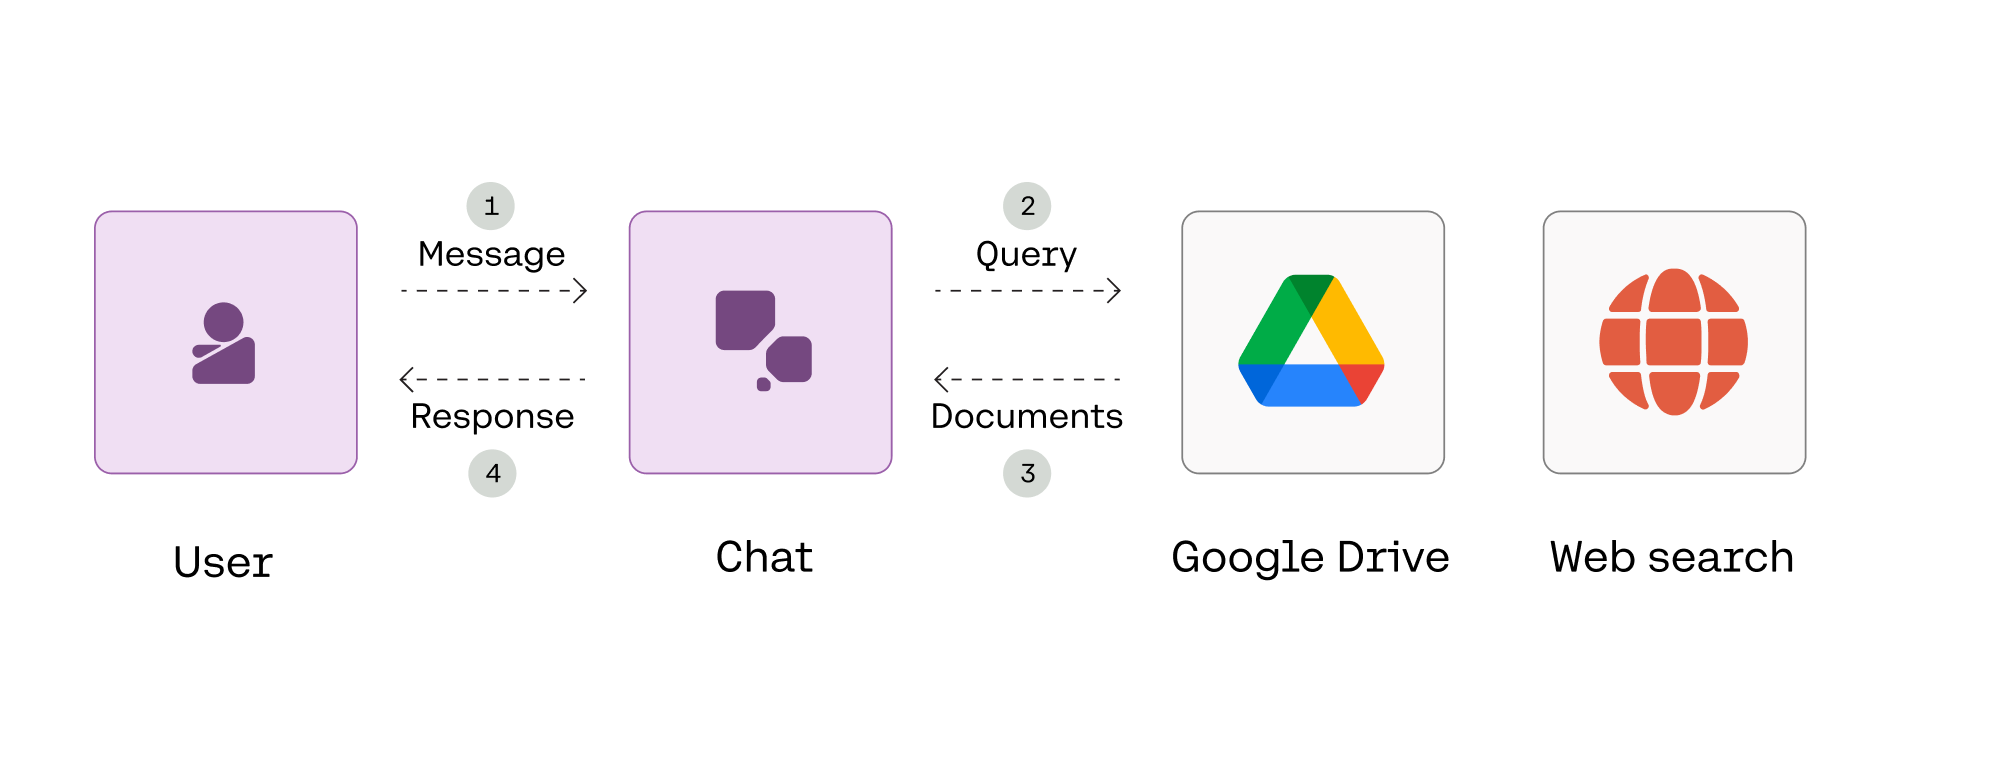

# Setup

In [ ]:
! pip install cohere -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.2 MB/s eta 0:00:00


In [1]:
import cohere
from cohere import ChatConnector
import uuid
from typing import List, Dict

co = cohere.Client("COHERE_API_KEY") # Get your API key here: https://dashboard.cohere.com/api-keys

In [ ]:
#@title Enable text wrapping in Google Colab

from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

# Create a chatbot

The Chatbot class below handles the interaction between the user and chatbot. We define the connector for the chatbot to use with the attribute self.connectors.

The run() method contains the logic for getting the user message, displaying the chatbot response with citations, along with a way for the user to end the conversation.

In [5]:
class Chatbot:
    def __init__(self, connectors: List[str]):
        """
        Initializes an instance of the Chatbot class.

        """
        self.conversation_id = str(uuid.uuid4())
        self.connectors = [ChatConnector(id=connector) for connector in connectors]

    def run(self):
        """
        Runs the chatbot application.

        """
        while True:
            # Get the user message
            message = input("User: ")

            # Typing "quit" ends the conversation
            if message.lower() == "quit":
                print("Ending chat.")
                break
            else:                       # If using Google Colab, remove this line to avoid printing the same thing twice
              print(f"User: {message}") # If using Google Colab, remove this line to avoid printing the same thing twice

            # Generate response
            response = co.chat_stream(
                    message=message,
                    model="command-r-plus",
                    conversation_id=self.conversation_id,
                    connectors=self.connectors,
            )

            # Print the chatbot response, citations, and documents
            print("\nChatbot:")
            citations = []
            cited_documents = []

            # Display response
            for event in response:
                if event.event_type == "text-generation":
                    print(event.text, end="")
                elif event.event_type == "citation-generation":
                    citations.extend(event.citations)
                elif event.event_type == "stream-end":
                    cited_documents = event.response.documents

            # Display citations and source documents
            if citations:
              print("\n\nCITATIONS:")
              for citation in citations:
                print(citation)

              print("\nDOCUMENTS:")
              for document in cited_documents:
                print({'id': document['id'],
                      'text': document.get('text', document.get('snippet', ''))[:50] + '...'}) # "text" for Gdrive, "snippet" for web search

            print(f"\n{'-'*100}\n")

# Run the chatbot

We can now run the chatbot.  For this, we create the instance of `Chatbot` using Cohere's managed web-search connector.  Then we run the chatbot by invoking the `run()` method.

The format of each citation is:
- `start`: The starting point of a span where one or more documents are referenced
- `end`: The ending point of a span where one or more documents are referenced
- `text`: The text representing this span
- `document_ids`: The IDs of the documents being referenced (`doc_0` being the ID of the first document passed to the `documents` creating parameter in the endpoint call, and so on)

The Chat endpoint can accept multiple connectors and retrieve information from all the defined connectors.

In [6]:
# Define connectors
connectors = ["demo-conn-gdrive-6bfrp6", "web-search"]

# Create an instance of the Chatbot class
chatbot = Chatbot(connectors)

# Run the chatbot
chatbot.run()

User: What is chain of thought prompting

Chatbot:
Chain-of-Thought (CoT) prompting is a technique used to guide Large Language Models (LLMs) to follow a reasoning process when dealing with complex problems. This is done by providing the model with a few examples where the step-by-step reasoning is clearly laid out. The model is then expected to follow that "chain of thought" reasoning to get to the correct answer.

CoT prompting is a prompt engineering technique that aims to improve language models' performance on tasks requiring logic, calculation and decision-making by structuring the input prompt in a way that mimics human reasoning.

To construct a chain-of-thought prompt, a user typically appends an instruction such as "Describe your reasoning in steps" or "Let's think step by step" to the end of their query to a large language model (LLM). This encourages the model to generate intermediate steps before providing a final answer.

CITATIONS:
start=17 end=22 text='(CoT)' document_i

With all these documents coming from various connectors, you may be asking a couple of questions:

- **How to handle long documents?** Connecting to multiple connectors means having to deal with various APIs, each with its own way of providing documents. Some may return a complete document with tens or hundreds of pages. There are a couple of problems with this. First, stuffing a long document into an LLM prompt means its context limit will be reached, resulting in an error. Second, even if the context limit is not reached, the LLM response will likely not be very good because it is getting a lot of irrelevant information from a long document instead of specific chunks from the document that are the most relevant.

- **How to handle multiple documents from multiple connectors and queries?** For a specific connector, the retrieval and reranking implementation is within the developer’s control. But with multiple connectors, that is not possible because these documents are aggregated at the Chat endpoint. As the number of connectors increases, this becomes a bigger problem because we don’t have control over the relevancy of the documents sent to the LLM prompt. And then there is the same problem of possible context limits being reached. Furthermore, if more than one query is generated, the number of documents retrieved will multiply with the same number.

The Chat endpoint solves these problems with its automated chunking and reranking process.

Note that for this to happen, the `prompt_truncation` parameter should be set as `AUTO` (default) and not `OFF`.

# Handling Long and Large Volume of Documents

### Chunking

The command-r family of models supports a large context length (128k tokens), offering ample room for retrieved documents. However, in the scenario where this context length is exceeded, the automated chunking feature will be activated. 

With every document sent by the connectors, the first step is to split it into smaller chunks. Each chunk is between 100 and 400 words, and sentences are kept intact where possible.


### Reranking

The Chat endpoint then uses the Rerank endpoint to take all the chunked documents from all connectors and rerank them based on contextual relevance to the query.

### Interleaving

The reranked documents from the different lists are then interleaved into one list.

### Prompt building
By setting the `prompt_truncation` parameter by setting it to `AUTO`, some elements from chat_history and documents will be dropped in an attempt to construct a prompt that fits within the model's context length limit.
Documents and chat history will be iteratively added until the prompt is too long. This prompt will be passed to the Command model for response generation.
